In [25]:
matplotlib.rc('image', cmap='Greys')

# Under the hood: training a digit classifier
---
This notebook reproduces chapter 4 of the fastai [book](https://github.com/fastai/fastbook) using the full MNIST datasets.

In [1]:
from fastai2.vision.all import *
from utils import *

## Part 1: Implementing a baseline, ie. pixel similarity

In [2]:
path = untar_data(URLs.MNIST) # use the full dataset

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [5]:
(path/'training').ls()

(#10) [Path('training/0'),Path('training/2'),Path('training/9'),Path('training/8'),Path('training/7'),Path('training/1'),Path('training/5'),Path('training/4'),Path('training/6'),Path('training/3')]

### *Collect all the paths to the images into a dictionary of lists using dictionary and list comprehensions*

In [6]:
fns = {i: [fn for fn in (path/f'training/{i}').ls()] for i in range(10)}
fns[0][:5]

[Path('training/0/53924.png'),
 Path('training/0/53387.png'),
 Path('training/0/2746.png'),
 Path('training/0/20762.png'),
 Path('training/0/15520.png')]

### *Open the images and convert them to tensors*

In [16]:
img_tensors = {key: [tensor(Image.open(pat)) for pat in paths] for (key, paths) in fns.items()}

In [17]:
img_tensors[9][1][7:15, 6:20]

tensor([[  0,   0,   0,   0,   0,   0,  10,  59, 120, 201, 254, 254, 254, 255],
        [  0,   0,   0,   0,  10,  50, 138, 253, 254, 253, 247, 236, 253, 254],
        [  0,   0,   0,  19, 122, 253, 253, 253, 175, 129,  54,  12, 137, 254],
        [  0,   0,  31, 164, 253, 240, 198,  41,   0,   0,   0,  52, 226, 254],
        [  0,  16, 217, 254, 207, 108,   0,   0,   0,   0,  68, 241, 253, 254],
        [ 19, 164, 254, 241, 142,   0,   0,   0,   0,  50, 156, 254, 254, 255],
        [ 94, 245, 253, 113,   0,   0,   0,   0, 118, 232, 253, 253, 253, 226],
        [199, 253, 154,  30,   0,   0,  73, 153, 254, 253, 253, 253, 253, 135]],
       dtype=torch.uint8)

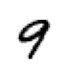

In [53]:
show_image(img_tensors[9][1])

In [20]:
df = pd.DataFrame(img_tensors[9][1][6:27, 5:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,10,59,120,201,254,254,254,255,158,0
2,0,0,0,0,0,10,50,138,253,254,253,247,236,253,254,250,104
3,0,0,0,0,19,122,253,253,253,175,129,54,12,137,254,253,175
4,0,0,0,31,164,253,240,198,41,0,0,0,52,226,254,253,189
5,0,0,16,217,254,207,108,0,0,0,0,68,241,253,254,245,86
6,0,19,164,254,241,142,0,0,0,0,50,156,254,254,255,196,30
7,0,94,245,253,113,0,0,0,0,118,232,253,253,253,226,21,0
8,7,199,253,154,30,0,0,73,153,254,253,253,253,253,135,0,0
9,35,253,253,163,40,85,166,251,253,254,219,203,253,237,0,0,0


### *Stack the tensors, convert them to floats and reduce range of pixel values to between zero and one*

In [21]:
stacked_tensors = {key: torch.stack(imgs).float() / 255 
                   for (key, imgs) in img_tensors.items()}

In [22]:
for k,v in stacked_tensors.items(): print(f'{k}: {v.shape}')

0: torch.Size([5923, 28, 28])
1: torch.Size([6742, 28, 28])
2: torch.Size([5958, 28, 28])
3: torch.Size([6131, 28, 28])
4: torch.Size([5842, 28, 28])
5: torch.Size([5421, 28, 28])
6: torch.Size([5918, 28, 28])
7: torch.Size([6265, 28, 28])
8: torch.Size([5851, 28, 28])
9: torch.Size([5949, 28, 28])


Good so now what we have is a dictionary containing the class as the keys and the stacked images as the values. Lets calculate the mean image for each class

In [23]:
mean_tensors = {key: imgs.mean(0) for (key, imgs) in stacked_tensors.items()}

### *Display the mean of all the classes*

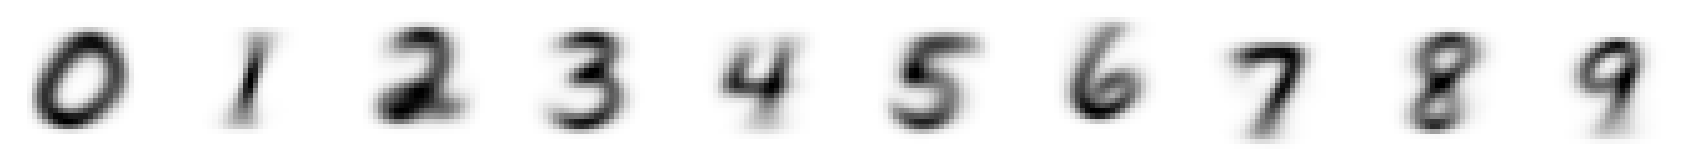

In [38]:
show_images(list(mean_tensors.values()))

### *Calculate similarity between images and the means*

Lets try that on a single image

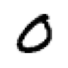

In [44]:
a_0 = stacked_tensors[0][1]
show_image(a_0)

We need to get the distance between our image and each of the 10 different classes, the minimum of them would be the predicted class

In [49]:
print(' '*5 + 'MAE    RMSE')
for key, mean in mean_tensors.items():
    dist_mae = (a_0 - mean).abs().mean()
    dist_rmse = ((a_0 - mean) ** 2).mean().sqrt()
    print(f'{key}: {dist_mae:.4f},  {dist_rmse:.4f}')

     MAE    RMSE
0: 0.1196,  0.2030
1: 0.1986,  0.3828
2: 0.2019,  0.3387
3: 0.1838,  0.3230
4: 0.1987,  0.3522
5: 0.1666,  0.2927
6: 0.1911,  0.3347
7: 0.1982,  0.3562
8: 0.1911,  0.3307
9: 0.1944,  0.3480


For both the **mean absolute error** and the **root mean squared error**, the minimum distance is that of the mean of 0

In [50]:
def diff(a, b): return (a - b).abs().mean((-1, -2))

In [52]:
diff(a_0, mean_tensors[0])

tensor(0.1196)

### **Prepare validation set**

In [57]:
valid_fns = {i: [fn for fn in (path/f'testing/{i}').ls()] for i in range(10)}
valid_stacked_tensors = {key: torch.stack([tensor(Image.open(pat)) for pat in paths]).float()/255 
                         for (key, paths) in valid_fns.items()}

In [58]:
for k,v in valid_stacked_tensors.items(): print(f'{k}: {v.shape}')

0: torch.Size([980, 28, 28])
1: torch.Size([1135, 28, 28])
2: torch.Size([1032, 28, 28])
3: torch.Size([1010, 28, 28])
4: torch.Size([982, 28, 28])
5: torch.Size([892, 28, 28])
6: torch.Size([958, 28, 28])
7: torch.Size([1028, 28, 28])
8: torch.Size([974, 28, 28])
9: torch.Size([1009, 28, 28])


Working with all the 10 classes is a little bit tricky. For each class in the validation set we would have to find the difference between all images in that class and the `10` means that we have. After we have to compare them to find the minimum (again for each image in that class) and check to see if that corresponds to the right class. Finally we find the accuracy based on the fraction of minimums that actually corresponded to right class. 

Lets walk through a simplified example to see how it plays out:
We find the similarity between the zeros in the validation set and means of `0`, `1` and `2`

In [82]:
diff_0 = diff(valid_stacked_tensors[0], mean_tensors[0])
diff_1 = diff(valid_stacked_tensors[0], mean_tensors[1])
diff_2 = diff(valid_stacked_tensors[0], mean_tensors[2])

diff_0.shape, diff_1.shape, diff_2.shape

(torch.Size([980]), torch.Size([980]), torch.Size([980]))

All of the differences are vectors of size `980` which makes sense because we have 980 zeros in the validations set. To make it easy to compare them to find the minimum for each of those 980 images lets combine them into a single tensor

In [83]:
diff_combined = torch.stack([diff_0, diff_1, diff_2]).T
diff_combined.shape

torch.Size([980, 3])

In [84]:
diff_combined[0]

tensor([0.1477, 0.1721, 0.1874])

Each row in `diff_combined` corresponds to the computed distances for a single image. So we can find the minimums across the columns inorder to calculate the accuracy.

In [86]:
mins = diff_combined.min(1)

The object returned by the call to min, has an `indices` property which tells us which index (ie. which column) was the minimum. We know that `0` was the first index so we just have to find the number of times the minimum index was `0` and sum over the total number of images.

In [89]:
(mins.indices == 0).float().mean()

tensor(0.8980)

### *Combine all the above steps into a function*

In [91]:
def cal_accuracy(imgs_dict, means_dict):
    accuracies = []
    for kv, images in imgs_dict.items(): 
        diffs = []
        for km, mean in means_dict.items():
            diffs.append(diff(images, mean))

        diffs = torch.stack(diffs).T
        mins = diffs.min(1)
        acc = (mins.indices == kv).float().mean()
        accuracies.append(acc)
    return accuracies

In [92]:
accuracies = cal_accuracy(valid_stacked_tensors, mean_tensors)

In [101]:
# print final stats
print('Class Accuracy')
for i, acc in enumerate(accuracies): print(f'{i}    {acc:.4f}')
    
print(f'Average accuracy: {tensor(accuracies).mean():.4f}')

Class Accuracy
0    0.8153
1    0.9982
2    0.4234
3    0.6089
4    0.6680
5    0.3262
6    0.7871
7    0.7646
8    0.4425
9    0.7760
Average accuracy: 0.6610


`66%` huh.... Not bad for an approach like this, let's try improving that with an actual learning algorithm